<a id=top></a>
# Correcting for Missing Wavecals with Cross-Correlation

<h1>Learning Goals<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span><ul class="toc-item"><li><span><a href="#Import-Necessary-Packages" data-toc-modified-id="Import-Necessary-Packages-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Necessary Packages</a></span></li><li><span><a href="#Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery" data-toc-modified-id="Collect-Data-Set-From-the-MAST-Archive-Using-Astroquery-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Collect Data Set From the MAST Archive Using Astroquery</a></span></li></ul></li><li><span><a href="#_x1d-Spectra-of-the-Observations" data-toc-modified-id="_x1d-Spectra-of-the-Observations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>_x1d Spectra of the Observations</a></span><ul class="toc-item"><li><span><a href="#Creating-Shifted-Spectrum" data-toc-modified-id="Creating-Shifted-Spectrum-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Creating Shifted Spectrum</a></span></li><li><span><a href="#Spectrum-Interpolation" data-toc-modified-id="Spectrum-Interpolation-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Spectrum Interpolation</a></span></li></ul></li><li><span><a href="#Cross-Correlation" data-toc-modified-id="Cross-Correlation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Cross-Correlation</a></span><ul class="toc-item"><li><span><a href="#Dispersion-per-Pixel" data-toc-modified-id="Dispersion-per-Pixel-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dispersion per Pixel</a></span></li><li><span><a href="#Masking-out-the-Lyman-alpha-line" data-toc-modified-id="Masking-out-the-Lyman-alpha-line-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Masking out the Lyman-alpha line</a></span></li><li><span><a href="#Lag-and-Cross-Correlation-Coefficient" data-toc-modified-id="Lag-and-Cross-Correlation-Coefficient-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Lag and Cross-Correlation Coefficient</a></span></li><li><span><a href="#Polynimial-Fitting-and-Zero-Point-Shift" data-toc-modified-id="Polynimial-Fitting-and-Zero-Point-Shift-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Polynimial Fitting and Zero Point Shift</a></span></li></ul></li><li><span><a href="#Recalibrate-Spectrum" data-toc-modified-id="Recalibrate-Spectrum-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Recalibrate Spectrum</a></span></li></ul></div>

## Introduction
If the wavelength calibration fails due to, for example, a bad acquisition, the zero point in the spectral direction of the spectrum might be shifted because of the imprecise target positioning. However, if the target was observed multiple times and at least one has the correct zero point, then this shift can be corrected using cross-correlation. In this notebook, we will go through how to fix the shifted spectrum by cross-correlating it with a calibrated one.

### Import Necessary Packages
- `astropy.io fits` `astropy.table Table` for accessing FITS files
- `astroquery.mast Observations` for finding and downloading data from the [MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html) archive
- `astropy.modeling fitting` `astropy.modeling.models Polynomial1D`for fitting polynomials
- `scipy.signal correlate` for performing cross-correlation
- `matplotlib` for plotting data
- `numpy` for handling array functions
- `stistools` for quick operations on STIS Data
- `os`,`shutil`,`pathlib` for managing system paths

In [1]:
from astropy.io import fits
from astroquery.mast import Observations

from astropy.modeling import fitting
from astropy.modeling.models import Polynomial1D

from scipy.signal import correlate
from scipy.signal import correlation_lags

import matplotlib.pyplot as plt

import numpy as np

import os
import shutil
from pathlib import Path

import stistools

The following tasks in the stistools package can be run with TEAL:
   basic2d      calstis     ocrreject     wavecal        x1d          x2d


/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/stsci/tools/nmpfit.py:8: UserWarning: NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.
  warnings.warn("NMPFIT is deprecated - stsci.tools v 3.5 is the last version to contain it.")
/opt/hostedtoolcache/Python/3.11.11/x64/lib/python3.11/site-packages/stsci/tools/gfit.py:18: UserWarning: GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it.Use astropy.modeling instead.
  warnings.warn("GFIT is deprecated - stsci.tools v 3.4.12 is the last version to contain it."


### Collect Data Set From the MAST Archive Using Astroquery
In this notebook, we need to download two datasets and explore their correlation.

In [2]:
# remove downlaod directory if it already exists
if os.path.exists("./mastDownload"):
    shutil.rmtree("./mastDownload")
# Search target object by obs_id
target_id = "odj101050"
ref_id = "odj101060"
target = Observations.query_criteria(obs_id=[target_id, ref_id])
# get a list of files assiciated with that target
target_list = Observations.get_product_list(target)
# Download only the SCIENCE fits files
Observations.download_products(target_list, productType="SCIENCE")

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/odj101050/odj101050_flt.fits,COMPLETE,None,None
./mastDownload/HST/odj101050/odj101050_raw.fits,COMPLETE,None,None
./mastDownload/HST/odj101050/odj101050_x1d.fits,COMPLETE,None,None
./mastDownload/HST/odj101050/odj101050_x2d.fits,COMPLETE,None,None
./mastDownload/HST/odj101060/odj101060_flt.fits,COMPLETE,None,None
./mastDownload/HST/odj101060/odj101060_raw.fits,COMPLETE,None,None
./mastDownload/HST/odj101060/odj101060_x1d.fits,COMPLETE,None,None
./mastDownload/HST/odj101060/odj101060_x2d.fits,COMPLETE,None,None


## _x1d Spectra of the Observations
### Creating Shifted Spectrum
In this notebook, we select two datasets of observations (odj101050, odj101060) with the same target (-PHI-LEO), detector (FUV-MAMA), and grating (G140M). We artificially shift one of the spectra (odj101050) to simulate the wavelength zeropoint shifted spectrum due to target acquisition failures, and use the other spectrum (odj101060) as the reference to conduct cross-correlation. To shift the spectrum, we set the "WAVECORR" calibration switch in the raw fits file to "OMIT" and recalibrate the spectrum using Calstis. "WAVECORR" is the calibration step that determines the shift of the image on the detector along each axis, and therefore by turning off the "WAVECORR" calibration switch, wavecal is not performed and the spectrum is systemetically shifted. We will then use the shifted spectrum and the reference spectrum to determine the wavelength zero point shift, recalibrate this shifted spectrum, and compare it with the original pipeline spectrum.

Next, use the [Calibration Reference Data System](https://hst-crds.stsci.edu) (CRDS) [command line tools](https://hst-crds.stsci.edu/static/users_guide/command_line_tools.html) to update and download the reference files.

In [3]:
crds_path = os.path.expanduser("~") + "/crds_cache"
os.environ["CRDS_PATH"] = crds_path
os.environ["CRDS_SERVER_URL"] = "https://hst-crds.stsci.edu"
os.environ["oref"] = os.path.join(crds_path, "references/hst/oref/")

In [4]:
!crds bestrefs --update-bestrefs --sync-references=1 --files ./mastDownload/HST/odj101050/odj101050_raw.fits

CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_wf4tfile_0250.rmap      678 bytes  (1 / 142 files) (0 / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_shadfile_0250.rmap      977 bytes  (2 / 142 files) (678 / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_offtab_0250.rmap      642 bytes  (3 / 142 files) (1.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_maskfile_0250.rmap      685 bytes  (4 / 142 files) (2.3 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_idctab_0250.rmap      696 bytes  (5 / 142 files) (3.0 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_flatfile_0250.rmap   30.0 K bytes  (6 / 142 files) (3.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_dgeofile_0250.rmap      801 bytes  (7 / 142 files) (33.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_darkfile_0250.rmap  178.4 K bytes  (8 / 142 files) (34.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_biasfile_0250.rmap    3.3 K bytes  (9 / 142 files) (212.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_atodfile_0250.rmap      874 bytes  (10 / 142 files) (216.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfpc2_0250.imap      782 bytes  (11 / 142 files) (217.0 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_snkcfile_0003.rmap      681 bytes  (12 / 142 files) (217.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_satufile_0002.rmap    1.0 K bytes  (13 / 142 files) (218.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_pfltfile_0253.rmap   34.2 K bytes  (14 / 142 files) (219.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_pctetab_0004.rmap      698 bytes  (15 / 142 files) (253.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_oscntab_0250.rmap      747 bytes  (16 / 142 files) (254.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_npolfile_0254.rmap    4.0 K bytes  (17 / 142 files) (255.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_nlinfile_0250.rmap      726 bytes  (18 / 142 files) (259.2 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_mdriztab_0254.rmap      845 bytes  (19 / 142 files) (259.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_imphttab_0257.rmap      683 bytes  (20 / 142 files) (260.7 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_idctab_0254.rmap      661 bytes  (21 / 142 files) (261.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_flshfile_0256.rmap    5.8 K bytes  (22 / 142 files) (262.1 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_drkcfile_0200.rmap  242.5 K bytes  (23 / 142 files) (267.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_dfltfile_0002.rmap   17.1 K bytes  (24 / 142 files) (510.3 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_darkfile_0499.rmap  289.8 K bytes  (25 / 142 files) (527.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_d2imfile_0251.rmap      605 bytes  (26 / 142 files) (817.2 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_crrejtab_0250.rmap      803 bytes  (27 / 142 files) (817.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_ccdtab_0250.rmap      799 bytes  (28 / 142 files) (818.6 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_bpixtab_0317.rmap   12.1 K bytes  (29 / 142 files) (819.4 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_biasfile_0267.rmap   23.4 K bytes  (30 / 142 files) (831.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_biacfile_0003.rmap      692 bytes  (31 / 142 files) (854.9 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_atodtab_0250.rmap      651 bytes  (32 / 142 files) (855.6 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_wfc3_0610.imap    1.3 K bytes  (33 / 142 files) (856.2 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_tmttab_0002.rmap      745 bytes  (34 / 142 files) (857.5 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_tmgtab_0012.rmap      767 bytes  (35 / 142 files) (858.2 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_tmctab_0055.rmap      743 bytes  (36 / 142 files) (859.0 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_thruput_0059.rmap  329.6 K bytes  (37 / 142 files) (859.8 K / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_thermal_0003.rmap   20.4 K bytes  (38 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_obsmodes_0004.rmap      743 bytes  (39 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_synphot_0070.imap      579 bytes  (40 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_xtractab_0250.rmap      815 bytes  (41 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_wcptab_0251.rmap      578 bytes  (42 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_teltab_0250.rmap      745 bytes  (43 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_tdstab_0254.rmap      921 bytes  (44 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_tdctab_0252.rmap      650 bytes  (45 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_srwtab_0250.rmap      745 bytes  (46 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_sptrctab_0251.rmap      895 bytes  (47 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_sdctab_0251.rmap      889 bytes  (48 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_riptab_0254.rmap      877 bytes  (49 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_phottab_0258.rmap    1.6 K bytes  (50 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_pfltfile_0250.rmap   23.7 K bytes  (51 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_pctab_0250.rmap    3.1 K bytes  (52 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_mofftab_0250.rmap      747 bytes  (53 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_mlintab_0250.rmap      601 bytes  (54 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_lfltfile_0250.rmap   11.8 K bytes  (55 / 142 files) (1.2 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_lamptab_0250.rmap      610 bytes  (56 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_inangtab_0250.rmap      815 bytes  (57 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_imphttab_0252.rmap      616 bytes  (58 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_idctab_0251.rmap      775 bytes  (59 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_halotab_0250.rmap      747 bytes  (60 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_gactab_0250.rmap      651 bytes  (61 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_exstab_0250.rmap      745 bytes  (62 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_echsctab_0250.rmap      749 bytes  (63 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_disptab_0250.rmap      813 bytes  (64 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_darkfile_0359.rmap   61.1 K bytes  (65 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_crrejtab_0250.rmap      711 bytes  (66 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_cdstab_0250.rmap      745 bytes  (67 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_ccdtab_0252.rmap      893 bytes  (68 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_bpixtab_0250.rmap      845 bytes  (69 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_biasfile_0361.rmap  121.7 K bytes  (70 / 142 files) (1.3 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_apertab_0250.rmap      588 bytes  (71 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_apdestab_0252.rmap      636 bytes  (72 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_stis_0375.imap    1.7 K bytes  (73 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_zprattab_0250.rmap      646 bytes  (74 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_tempfile_0250.rmap    1.1 K bytes  (75 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_tdffile_0250.rmap    8.9 K bytes  (76 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_saadfile_0250.rmap      771 bytes  (77 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_saacntab_0250.rmap      594 bytes  (78 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_rnlcortb_0250.rmap      771 bytes  (79 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_pmskfile_0250.rmap      603 bytes  (80 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_pmodfile_0250.rmap      603 bytes  (81 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_phottab_0250.rmap      862 bytes  (82 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_pedsbtab_0250.rmap      594 bytes  (83 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_noisfile_0250.rmap    2.6 K bytes  (84 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_nlinfile_0250.rmap    1.7 K bytes  (85 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_maskfile_0250.rmap    1.2 K bytes  (86 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_illmfile_0250.rmap    5.8 K bytes  (87 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_idctab_0250.rmap      767 bytes  (88 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_flatfile_0250.rmap   11.0 K bytes  (89 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_darkfile_0250.rmap   14.9 K bytes  (90 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_nicmos_0250.imap    1.1 K bytes  (91 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_ywlkfile_0003.rmap      922 bytes  (92 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_xwlkfile_0002.rmap      922 bytes  (93 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_xtractab_0269.rmap    1.6 K bytes  (94 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_wcptab_0257.rmap    1.3 K bytes  (95 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_twozxtab_0277.rmap      990 bytes  (96 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_tracetab_0276.rmap      998 bytes  (97 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_tdstab_0272.rmap      803 bytes  (98 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_spwcstab_0255.rmap    1.1 K bytes  (99 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_spottab_0006.rmap      766 bytes  (100 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_proftab_0276.rmap    1.0 K bytes  (101 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_phatab_0250.rmap      668 bytes  (102 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_lamptab_0264.rmap    1.4 K bytes  (103 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_hvtab_0259.rmap      567 bytes  (104 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_hvdstab_0002.rmap    1.0 K bytes  (105 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_gsagtab_0261.rmap      712 bytes  (106 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_geofile_0250.rmap      670 bytes  (107 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_fluxtab_0282.rmap    1.7 K bytes  (108 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_flatfile_0264.rmap    1.8 K bytes  (109 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_disptab_0276.rmap    1.7 K bytes  (110 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_dgeofile_0002.rmap      909 bytes  (111 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_deadtab_0250.rmap      711 bytes  (112 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_brsttab_0250.rmap      696 bytes  (113 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_brftab_0250.rmap      614 bytes  (114 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_bpixtab_0260.rmap      773 bytes  (115 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_badttab_0252.rmap      643 bytes  (116 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_cos_0359.imap     1.4 K bytes  (117 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_spottab_0251.rmap      641 bytes  (118 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_snkcfile_0103.rmap    7.6 K bytes  (119 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_shadfile_0251.rmap      531 bytes  (120 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_satufile_0002.rmap    1.2 K bytes  (121 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_pfltfile_0253.rmap   69.2 K bytes  (122 / 142 files) (1.5 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_pctetab_0254.rmap      615 bytes  (123 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_oscntab_0251.rmap      781 bytes  (124 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_npolfile_0253.rmap    3.2 K bytes  (125 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_mlintab_0250.rmap      646 bytes  (126 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_mdriztab_0253.rmap      769 bytes  (127 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_imphttab_0260.rmap      769 bytes  (128 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_idctab_0256.rmap    1.5 K bytes  (129 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_flshfile_0268.rmap    3.4 K bytes  (130 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_drkcfile_0454.rmap   15.2 K bytes  (131 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_dgeofile_0250.rmap    3.2 K bytes  (132 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_darkfile_0445.rmap   87.1 K bytes  (133 / 142 files) (1.6 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_d2imfile_0253.rmap      601 bytes  (134 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_crrejtab_0251.rmap      945 bytes  (135 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_cfltfile_0250.rmap    1.2 K bytes  (136 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_ccdtab_0256.rmap    1.4 K bytes  (137 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_bpixtab_0253.rmap    1.1 K bytes  (138 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_biasfile_0443.rmap   57.2 K bytes  (139 / 142 files) (1.7 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_atodtab_0251.rmap      528 bytes  (140 / 142 files) (1.8 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_acs_0546.imap     1.3 K bytes  (141 / 142 files) (1.8 M / 1.8 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/mappings/hst/hst_1211.pmap           495 bytes  (142 / 142 files) (1.8 M / 1.8 M bytes)


CRDS - INFO -  No comparison context or source comparison requested.


CRDS - INFO -  ===> Processing ./mastDownload/HST/odj101050/odj101050_raw.fits


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/16j16005o_apd.fits   49.0 K bytes  (1 / 26 files) (0 / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/16j1600ao_sdc.fits  167.0 K bytes  (2 / 26 files) (49.0 K / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/16j1600co_wcp.fits   20.2 K bytes  (3 / 26 files) (216.0 K / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/3ah1528co_tds.fits   57.6 K bytes  (4 / 26 files) (236.2 K / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/6471930po_pht.fits    4.3 M bytes  (5 / 26 files) (293.8 K / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/6471930to_rip.fits    4.1 M bytes  (6 / 26 files) (4.6 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/77o18274o_imp.fits  800.6 K bytes  (7 / 26 files) (8.7 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/77o1827do_1dt.fits    4.4 M bytes  (8 / 26 files) (9.5 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/h1v1541eo_iac.fits   11.5 K bytes  (9 / 26 files) (13.9 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/h4s1350io_moc.fits   11.5 K bytes  (10 / 26 files) (13.9 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/j9r16559o_lin.fits   11.5 K bytes  (11 / 26 files) (13.9 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/k8m09584o_cds.fits    8.6 K bytes  (12 / 26 files) (14.0 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/k8m09585o_ech.fits    1.0 M bytes  (13 / 26 files) (14.0 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/k8m09586o_exs.fits   11.5 K bytes  (14 / 26 files) (15.0 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/k8m09587o_hal.fits   67.1 M bytes  (15 / 26 files) (15.0 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/k8m09589o_srw.fits   11.5 K bytes  (16 / 26 files) (82.1 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/k8m0958ao_tel.fits  933.1 K bytes  (17 / 26 files) (82.1 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/l421050oo_lmp.fits    7.2 M bytes  (18 / 26 files) (83.0 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/m1b2139no_lfl.fits  673.9 K bytes  (19 / 26 files) (90.3 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/m7p16110o_dsp.fits  342.7 K bytes  (20 / 26 files) (90.9 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/mbj1658bo_pfl.fits   42.0 M bytes  (21 / 26 files) (91.3 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/n7p10323o_1dx.fits  129.6 K bytes  (22 / 26 files) (133.3 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/q591955ro_drk.fits   42.0 M bytes  (23 / 26 files) (133.4 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/uce15153o_bpx.fits  521.3 K bytes  (24 / 26 files) (175.3 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/y2r1559to_apt.fits   11.6 M bytes  (25 / 26 files) (175.9 M / 187.5 M bytes)


CRDS - INFO -  Fetching  /home/runner/crds_cache/references/hst/stis/y2r16005o_pct.fits   89.3 K bytes  (26 / 26 files) (187.4 M / 187.5 M bytes)


CRDS - INFO -  0 errors
CRDS - INFO -  0 warnings
CRDS - INFO -  170 infos


In [5]:
pip_raw = os.path.join("./mastDownload/HST", "{}".format(target_id), "{}_raw.fits".format(target_id))
# Set the "WAVECORR" switch in the raw fits file header to "OMIT"
fits.setval(pip_raw, "WAVECORR", value="OMIT")

# Create and clean "./Shifted" directory for saving new files
shifted_dir = Path("./Shifted")
if os.path.exists(shifted_dir):
    shutil.rmtree(shifted_dir)
Path(shifted_dir).mkdir(exist_ok=True)

In [6]:
# Recalibration
res = stistools.calstis.calstis(pip_raw, verbose=False, outroot="./Shifted/")
# calstis returns 0 if calibration completes; if not, raise assertion error
assert res == 0, f"CalSTIS exited with an error:  {res}"


*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    13-Feb-2025 16:42:42 UTC

Input    ./mastDownload/HST/odj101050/odj101050_raw.fits
Outroot  ./Shifted/odj101050_raw.fits

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    13-Feb-2025 16:42:42 UTC
Input    ./mastDownload/HST/odj101050/odj101050_raw.fits
Output   ./Shifted/odj101050_flt.fits
OBSMODE  ACCUM
APERTURE 52X0.2
OPT_ELEM G140M
DETECTOR FUV-MAMA

Imset 1  Begin 16:42:42 UTC

DQICORR  PERFORM
DQITAB   oref$uce15153o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =New BPIXTAB with opt_elem column and correct repeller wire flag----


DQICORR  COMPLETE
         Uncertainty array initialized.

LORSCORR PERFORM


LORSCORR COMPLETE

GLINCORR PERFORM
LFLGCORR PERFORM
MLINTAB  oref$j9r16559o_lin.fits
MLINTAB  PEDIGREE=GROUND
MLINTAB  DESCRIP =T. Danks gathered Info
MLINTAB  DESCRIP =T. Danks Gathered Info
GLINCORR COMPLETE
LFLGCORR COMPLETE

DARKCORR PERFORM
DARKFILE oref$q591955ro_drk.fits
DARKFILE PEDIGREE=INFLIGHT 29/01/2003 03/08/2004
DARKFILE DESCRIP =Avg of 152 1380s darks from 9615 10034
DARKCORR COMPLETE

FLATCORR PERFORM
PFLTFILE oref$mbj1658bo_pfl.fits
PFLTFILE PEDIGREE=INFLIGHT 17/03/1998 17/05/2002
PFLTFILE DESCRIP =On-orbit FUV P-flat created from proposals 7645,8428,8862,8922
LFLTFILE oref$m1b2139no_lfl.fits
LFLTFILE PEDIGREE=DUMMY
LFLTFILE DESCRIP =Dummy file created by M. Mcgrath. Modified by C Proffitt


FLATCORR COMPLETE

PHOTCORR OMIT

DOPPCORR applied to DQICORR, DARKCORR, FLATCORR

STATFLAG PERFORM
STATFLAG COMPLETE


Imset 1  End 16:42:42 UTC

End      13-Feb-2025 16:42:42 UTC

*** CALSTIS-1 complete ***

*** CALSTIS-7 -- Version 3.4.2 (19-Jan-2018) ***
Begin    13-Feb-2025 16:42:42 UTC
Input    ./Shifted/odj101050_flt.fits
Output   ./Shifted/odj101050_x2d.fits
OBSMODE  ACCUM
APERTURE 52X0.2
OPT_ELEM G140M
DETECTOR FUV-MAMA
Imset 1  Begin 16:42:42 UTC
Warning  Wavecal processing has not been performed.

HELCORR  PERFORM
HELCORR  COMPLETE

Order 1  Begin 16:42:42 UTC

X2DCORR  PERFORM
DISPCORR PERFORM
APDESTAB oref$16j16005o_apd.fits
APDESTAB PEDIGREE=INFLIGHT 01/03/1997 13/06/2017
APDESTAB DESCRIP =Aligned long-slit bar positions for single-bar cases.--------------
APDESTAB DESCRIP =Microscope Meas./Hartig Post-launch Offsets
SDCTAB   oref$16j1600ao_sdc.fits
SDCTAB   PEDIGREE=INFLIGHT 13/07/1997 13/06/2017
SDCTAB   DESCRIP =Co-aligned fiducial bars via an update to the CDELT2 plate scales.-
SDCTAB   DESCRIP =updated CDELT2 with inflight data, others Lindler-prelaunch
DISPTAB  oref$m7p16110o_dsp.fit

<a id='shifted'></a>
As seen in the plot, the spectrum is now shifted compared to the pipeline spectrum:

Text(0.5, 1.0, 'Pipeline and Shifted _x1d Spectrum')

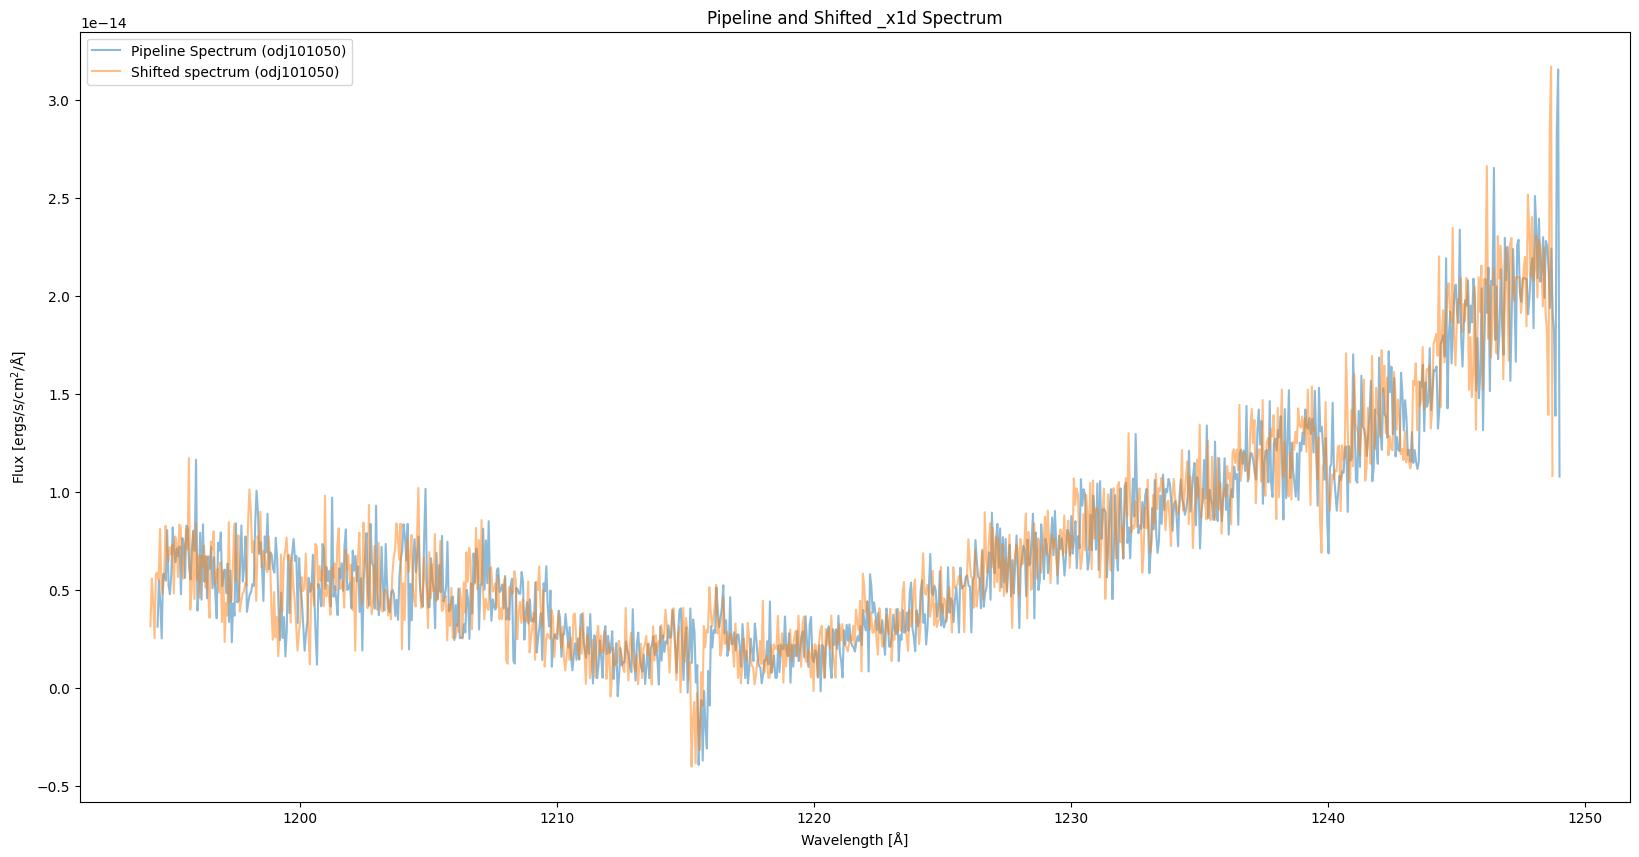

In [7]:
pip_x1d = os.path.join("./mastDownload/HST", "{}".format(target_id), "{}_x1d.fits".format(target_id))
shifted_x1d = Path("./Shifted/{}_x1d.fits".format(target_id))

with fits.open(pip_x1d) as hdu1, fits.open(shifted_x1d) as hdu2:
    pip_wl = hdu1[1].data["WAVELENGTH"][0]
    pip_flux = hdu1[1].data["FLUX"][0]
    
    shifted_wl = hdu2[1].data["WAVELENGTH"][0]
    shifted_flux = hdu2[1].data["FLUX"][0]

fig = plt.figure(figsize=(20, 10))
plt.plot(pip_wl, pip_flux, label="Pipeline Spectrum ({})".format(target_id), alpha=0.5)
plt.plot(shifted_wl, shifted_flux, label="Shifted spectrum ({})".format(target_id), alpha=0.5)
plt.legend(loc="best")
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [ergs/s/cm$^2$/Å]")
plt.title("Pipeline and Shifted _x1d Spectrum")

### Spectrum Interpolation
Since the wavelength range of the pipeline and shifted spectra are different, we interpolate one of the spectra based on the wavelength of the other one so that the two spectra share the same wavelength array. As shown in the plot, the spectrum with "WAVECORR" turned off is systemetically shifted to the left.

Text(0.5, 1.0, 'Reference and Shifted _x1d Spectrum')

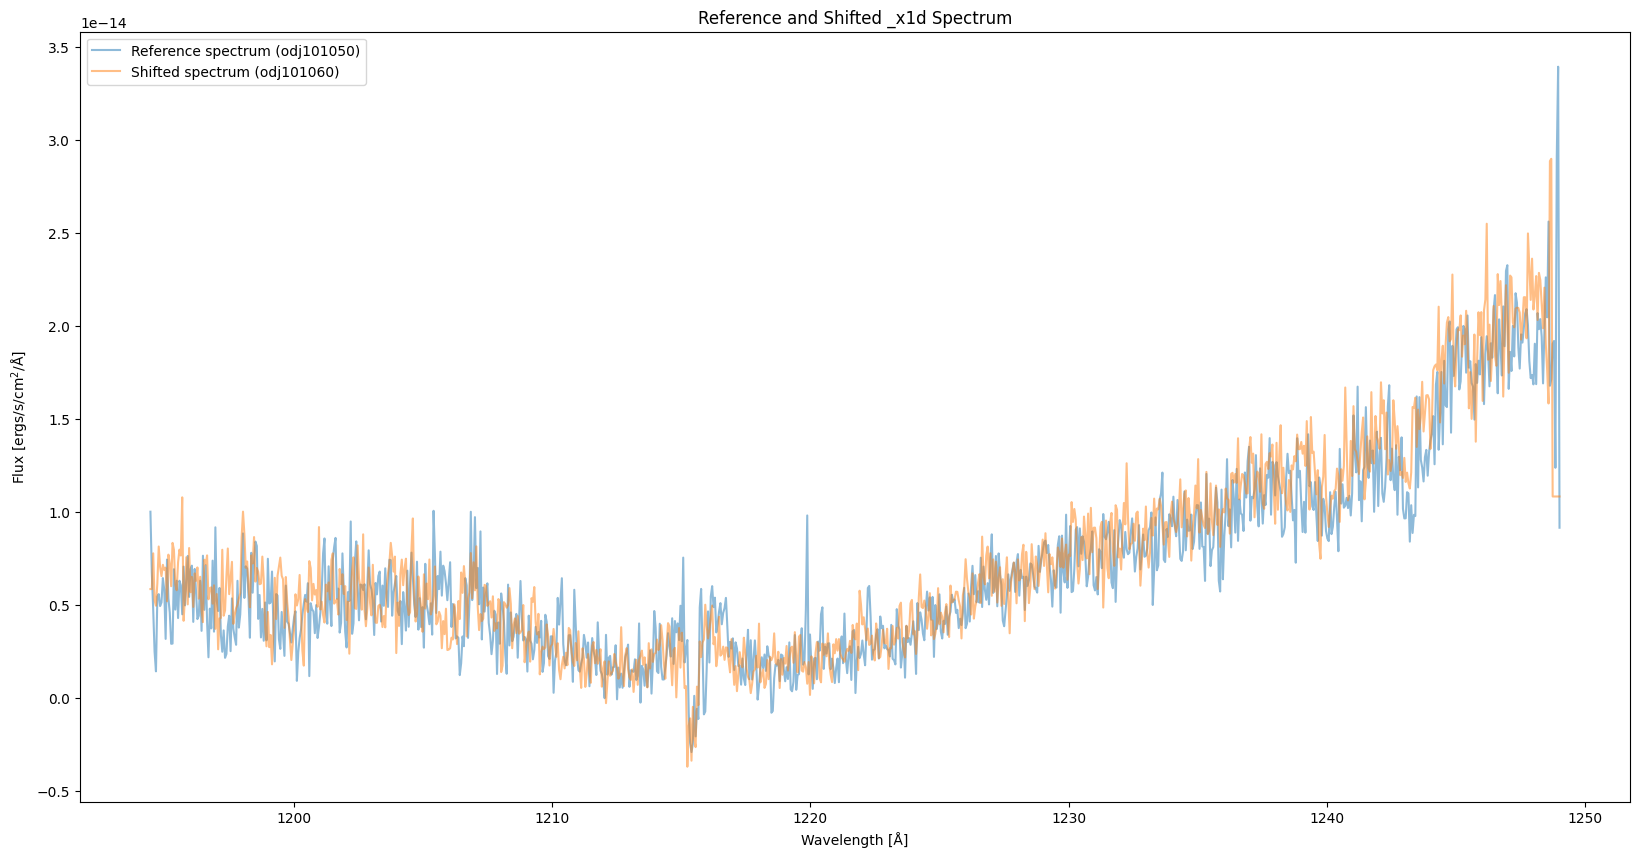

In [8]:
ref_x1d = os.path.join("./mastDownload/HST", "{}".format(ref_id), "{}_x1d.fits".format(ref_id))

with fits.open(ref_x1d) as hdu1, fits.open(shifted_x1d) as hdu2:
    wl = hdu1[1].data["WAVELENGTH"][0]
    ref_flux = hdu1[1].data["FLUX"][0]
    
    shifted_wl = hdu2[1].data["WAVELENGTH"][0]
    shifted_flux = hdu2[1].data["FLUX"][0]
    
    shifted_flux = np.interp(wl, shifted_wl, shifted_flux)

fig = plt.figure(figsize=(20, 10))
plt.plot(wl, ref_flux, alpha=0.5, label="Reference spectrum ({})".format(target_id))
plt.plot(wl, shifted_flux, alpha=0.5, label="Shifted spectrum ({})".format(ref_id))
plt.legend(loc="best")
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [ergs/s/cm$^2$/Å]")
plt.title("Reference and Shifted _x1d Spectrum")

## Cross-Correlation

### Dispersion per Pixel
To perform cross-correlation, detemine the shift amount in pixels, and then convert it into wavelength, we first need to determine the dispersion per pixel, i.e., the mean differences of adjacent data points in the wavelength grid.

In [9]:
mean_plate_scale = np.mean(wl[1:]-wl[:-1])
mean_plate_scale
print("The dispersion per pixel is {:.3f}".format(mean_plate_scale) + " Å/pixel")

The dispersion per pixel is 0.053 Å/pixel


### Masking out the Lyman-alpha line
The absorption line at around 1215 Å is from Hydrogen Lyman-alpha, which mostly comes from the atmosphere and so should not shift like the science spectrum. Therefore, we need to mask out this region by separating the spectrum into two parts and perform two cross-correlations. There are other airglows lines in the ultraviolet that also does not shift with the science spectrum, including OI line at 1302 Å, OI line at 1305 Å, OI line at 1306 Å. For more information on the Airglow, see: [`AIRGLOW`](https://www.stsci.edu/hst/instrumentation/cos/calibration/airglow).

In [10]:
# the spectrum on the right of Lyman-alpha
ref_flux1 = ref_flux[wl > 1220]
shifted_flux1 = shifted_flux[wl > 1220]

# the spectrum on the left of Lyman-alpha
ref_flux2 = ref_flux[wl < 1213]
shifted_flux2 = shifted_flux[wl < 1213]

### Lag and Cross-Correlation Coefficient

The lag is the displacement (in pixels) in the lagged spectrum. If the lag is 0, the spectra are aligned and not shifted.


The cross-correlation coefficient decodes how similar two spectra are. The cross-correlation coefficient takes values from -1 to 1: if it's positive, the 2 spectra are positively correlated, if it's negative, the 2 spectra are negatively correlated. 

The cross-correlation algorithm shifts one of the input spectra according the the lags, and computes the cross-correlation coefficient for each lag. Then we take the lag with the maximum cross-coefficient and compute the corresponding displacement in wavelength space.

In general, the cross-correlation can be written as:

<p style="text-align: center;">$C_{xy}[k]=\sum_n x[n] y[n+k]$</p>

in which k is the lag, C is the cross-correlation coefficient, and x and y are the input spectra.

**Normalization of the input spectra is required to ensure the cross-correlation coefficient is in the [-1,1] range.**

In [11]:
def cross_correlate(shifted_flux, ref_flux):
    assert len(shifted_flux) == len(ref_flux), "Arrays must be same size"
    
    # Normalize inputs:
    shifted_flux = shifted_flux - shifted_flux.mean()
    shifted_flux /= shifted_flux.std()
    ref_flux = ref_flux - ref_flux.mean()
    ref_flux /= ref_flux.std()
    
    # centered at the median of len(a)
    lag = correlation_lags(len(shifted_flux), len(ref_flux), mode="same") 
    # find the cross-correlation coefficient
    cc = correlate(shifted_flux, ref_flux, mode="same") / float(len(ref_flux))
        
    return lag, cc

### Polynimial Fitting and Zero Point Shift
After we get the lag and cross-correlation coefficient, we can determine the zero point shift by finding the lag with the maximum cross-correlation coefficient. However, since we only have discrete pixels shifts, we will fit a quadratic curve near the peak, get a fractional pixel shift, and find the maxima of the quadratic curve as the zero point shift. The zero point shift is shown as the green vertical line in the plot.

In this specific case, we choose the lag from -3 to 3, and fitted a 2 degree polynomial curve around the maximum cross-correlation coefficient to determine the shift in pixel space.**The lag range and polynomial fitting is not the single solution that can be applied to all cases of wavelength zero point shifts. Users should experiment with the lag range and number of points to fit the polynomial curve based on the use case.**

We first find the lag and cross-correlation coefficient of the right part of the spectrum:

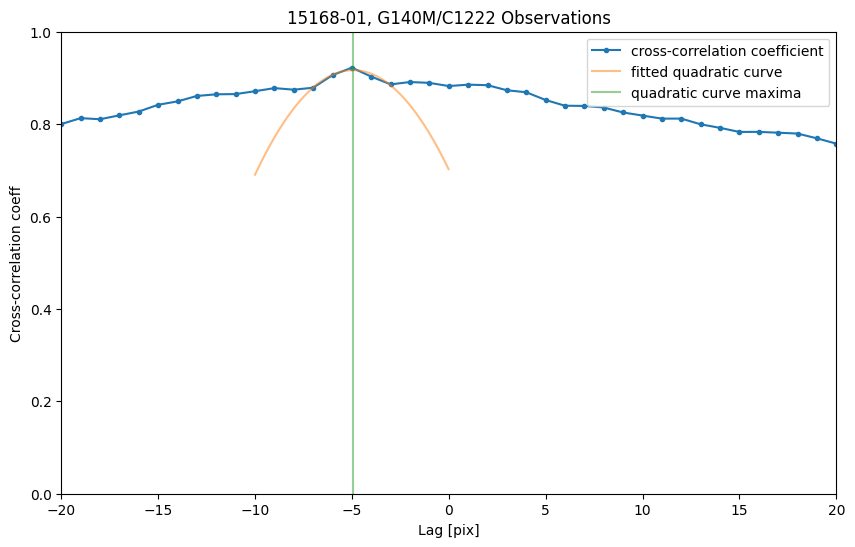

In [12]:
fig = plt.figure(figsize=(10, 6))
lag, cc = cross_correlate(shifted_flux1, ref_flux1)
plt.plot(lag, cc, ".-", label="cross-correlation coefficient")

# fit quadratic near the peak to find the pixel shift
fitter = fitting.LinearLSQFitter()
# get the 5 points near the peak
width = 5
low, hi = np.argmax(cc) - width//2, np.argmax(cc) + width//2 + 1
fit = fitter(Polynomial1D(degree=2), x=lag[low:hi], y=cc[low:hi])
x_c = np.arange(-10, 0, 0.01)
plt.plot(x_c, fit(x_c), alpha=0.5, label="fitted quadratic curve")
# finding the maxima
shift1 = -fit.parameters[1] / (2. * fit.parameters[2])
plt.plot([shift1, shift1], [0, 1], alpha=0.5, label="quadratic curve maxima")

plt.xlim(-20, 20)
plt.ylim(0, 1)
plt.xlabel("Lag [pix]")
plt.ylabel("Cross-correlation coeff")
plt.title("15168-01, G140M/C1222 Observations")
plt.legend(loc="best")

Convert the lag back into zero point shift in wavelength space:

In [13]:
print("Shift between the G140M/c1222 observations is {:.3f} pix = {:.3f}".format(shift1, shift1 * mean_plate_scale) + "Å")

Shift between the G140M/c1222 observations is -4.936 pix = -0.263Å


Apply the same procedure to the left part of the spectrum:

shift2 between the G140M/c1222 observations is -3.953 pix = -0.211Å


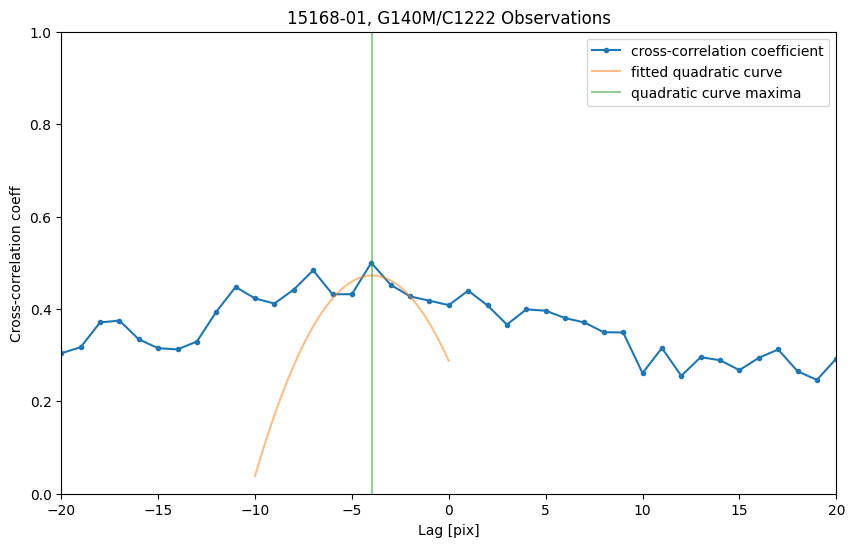

In [14]:
fig = plt.figure(figsize=(10, 6))
lag, cc = cross_correlate(shifted_flux2, ref_flux2)
plt.plot(lag, cc, ".-", label="cross-correlation coefficient")

# fit quadratic near the peak to find the pixel shift
fitter = fitting.LinearLSQFitter()
# get the 5 points near the peak
width = 5
low, hi = np.argmax(cc) - width//2, np.argmax(cc) + width//2 + 1
fit = fitter(Polynomial1D(degree=2), x=lag[low:hi], y=cc[low:hi])
x_c = np.arange(-10, 0, 0.01)
plt.plot(x_c, fit(x_c), alpha=0.5, label="fitted quadratic curve")
# finding the maxima
shift2 = -fit.parameters[1] / (2. * fit.parameters[2])
plt.plot([shift2, shift2], [0, 1], alpha=0.5, label="quadratic curve maxima")

plt.xlim(-20, 20)
plt.ylim(0, 1)
plt.xlabel("Lag [pix]")
plt.ylabel("Cross-correlation coeff")
plt.title("15168-01, G140M/C1222 Observations")
plt.legend(loc="best")
print("shift2 between the G140M/c1222 observations is {:.3f} pix = {:.3f}".format(shift2, shift2 * mean_plate_scale) + "Å")

However, as shown in the plot, the maximum cross-correlation coefficient (~0.5) is relatively small, which suggests that the spectra are less similar on the left side. With such a small cross-correlation coefficient, we cannot determine a reasonable shift in the pixel space. Therefore, we only take the shift determined by the right part of the spectrum as the shift of the spectrum:

In [15]:
shift = shift1
print("shift between the G140M/c1222 observations is {:.3f} pix = {:.3f}".format(shift, shift * mean_plate_scale) + "Å")

shift between the G140M/c1222 observations is -4.936 pix = -0.263Å


## Recalibrate Spectrum
After we determine the wavelength zero point shift, we can use the value to recalibrate the spectrum.

In the Calstis pipeline, "WAVECORR" calibration step determines the spectral shift values, and writes the keyword values SHIFTA1, SHIFTA2 for the spectral and spatial shifts, respectively, to the science header. To apply the spectral shift from the cross-correlation, we get the SHIFTA1, SHIFTA2 keywords from the _flt fits file, add the shift (in pixel space) to SHIFTA1, and write the updated keywords to the _raw fits file.

In [16]:
# get SHIFTA1, SHIFTA1 keywords from the first science extension
shifted_flt = Path("./Shifted/{}_flt.fits".format(target_id))
# since we have turned off WAVECOR at the beginning, SHIFTA1 should be 0
SHIFTA1 = fits.getval(shifted_flt, "SHIFTA1", 1)
SHIFTA2 = fits.getval(shifted_flt, "SHIFTA2", 1)
assert (SHIFTA1 == 0 and SHIFTA2 == 0)
# update SHIFTA1 (only in the spectral direction)
SHIFTA1 += shift
# update the the SHIFTA1, SHIFTA1 keywords in the _raw fits file first science extension
fits.setval(pip_raw, "SHIFTA1", value=SHIFTA1, ext=1)
fits.setval(pip_raw, "SHIFTA2", value=SHIFTA2, ext=1)

Then we need to turn the "WAVECORR" calibration switch to "omit" so that the Calstis calibration pipeline takes our new computed value instead of the wavecal returned value as the wavelength zero point shift.

In [17]:
fits.setval(pip_raw, "WAVECORR", value="OMIT", ext=0)
assert fits.getval(pip_raw, keyword="WAVECORR", ext=0) == "OMIT"

Recalibrate the spectrum using the Calstis pipeline. We create a new folder called "Recalibration" to store the recalibrated files. For more information on the Calstis pipeline, see: [STIS Calibration](https://hst-docs.stsci.edu/stisdhb/chapter-3-stis-calibration), [calstis](https://stistools.readthedocs.io/en/latest/calstis.html).

In [18]:
# Create and clean "./Recalibration" directory for saving new files
if os.path.exists("./Recalibration"):
    shutil.rmtree("./Recalibration")
Path("./Recalibration").mkdir(exist_ok=True)
# Recalibration
res = stistools.calstis.calstis(pip_raw, verbose=False, outroot="./Recalibration/")
# calstis returns 0 if calibration completes; if not, raise assertion error
assert res == 0, f"CalSTIS exited with an error:  {res}"
recal_x1d = Path("./Recalibration/{}_x1d.fits".format(target_id))


*** CALSTIS-0 -- Version 3.4.2 (19-Jan-2018) ***
Begin    13-Feb-2025 16:42:43 UTC

Input    ./mastDownload/HST/odj101050/odj101050_raw.fits
Outroot  ./Recalibration/odj101050_raw.fits

*** CALSTIS-1 -- Version 3.4.2 (19-Jan-2018) ***
Begin    13-Feb-2025 16:42:43 UTC
Input    ./mastDownload/HST/odj101050/odj101050_raw.fits
Output   ./Recalibration/odj101050_flt.fits
OBSMODE  ACCUM
APERTURE 52X0.2
OPT_ELEM G140M
DETECTOR FUV-MAMA

Imset 1  Begin 16:42:43 UTC



DQICORR  PERFORM
DQITAB   oref$uce15153o_bpx.fits
DQITAB   PEDIGREE=GROUND
DQITAB   DESCRIP =New BPIXTAB with opt_elem column and correct repeller wire flag----
DQICORR  COMPLETE
         Uncertainty array initialized.

LORSCORR PERFORM
LORSCORR COMPLETE

GLINCORR PERFORM
LFLGCORR PERFORM
MLINTAB  oref$j9r16559o_lin.fits
MLINTAB  PEDIGREE=GROUND
MLINTAB  DESCRIP =T. Danks gathered Info
MLINTAB  DESCRIP =T. Danks Gathered Info
GLINCORR COMPLETE
LFLGCORR COMPLETE

DARKCORR PERFORM
DARKFILE oref$q591955ro_drk.fits
DARKFILE PEDIGREE=INFLIGHT 29/01/2003 03/08/2004
DARKFILE DESCRIP =Avg of 152 1380s darks from 9615 10034


DARKCORR COMPLETE

FLATCORR PERFORM
PFLTFILE oref$mbj1658bo_pfl.fits
PFLTFILE PEDIGREE=INFLIGHT 17/03/1998 17/05/2002
PFLTFILE DESCRIP =On-orbit FUV P-flat created from proposals 7645,8428,8862,8922
LFLTFILE oref$m1b2139no_lfl.fits
LFLTFILE PEDIGREE=DUMMY
LFLTFILE DESCRIP =Dummy file created by M. Mcgrath. Modified by C Proffitt


FLATCORR COMPLETE

PHOTCORR OMIT

DOPPCORR applied to DQICORR, DARKCORR, FLATCORR

STATFLAG PERFORM
STATFLAG COMPLETE
Imset 1  End 16:42:43 UTC

End      13-Feb-2025 16:42:43 UTC

*** CALSTIS-1 complete ***

*** CALSTIS-7 -- Version 3.4.2 (19-Jan-2018) ***
Begin    13-Feb-2025 16:42:43 UTC
Input    ./Recalibration/odj101050_flt.fits
Output   ./Recalibration/odj101050_x2d.fits
OBSMODE  ACCUM
APERTURE 52X0.2
OPT_ELEM G140M
DETECTOR FUV-MAMA
Imset 1  Begin 16:42:43 UTC
Warning  Wavecal processing has not been performed.

HELCORR  PERFORM
HELCORR  COMPLETE

Order 1  Begin 16:42:43 UTC

X2DCORR  PERFORM
DISPCORR PERFORM
APDESTAB oref$16j16005o_apd.fits
APDESTAB PEDIGREE=INFLIGHT 01/03/1997 13/06/2017
APDESTAB DESCRIP =Aligned long-slit bar positions for single-bar cases.--------------
APDESTAB DESCRIP =Microscope Meas./Hartig Post-launch Offsets
SDCTAB   oref$16j1600ao_sdc.fits
SDCTAB   PEDIGREE=INFLIGHT 13/07/1997 13/06/2017
SDCTAB   DESCRIP =Co-aligned fiducial bars via an update to the C

BACKCORR PERFORM
******** Calling Slfit ***********BACKCORR COMPLETE
X1DCORR  COMPLETE
         Spectrum extracted at y position = 390.008

DISPCORR PERFORM
DISPTAB  oref$m7p16110o_dsp.fits
DISPTAB  PEDIGREE=INFLIGHT 04/03/1999 04/03/1999
DISPTAB  DESCRIP =Dispersion coefficients reference table
DISPTAB  DESCRIP =INFLIGHT Cal. Disp. Coeffs
APDESTAB oref$16j16005o_apd.fits
APDESTAB PEDIGREE=INFLIGHT 01/03/1997 13/06/2017
APDESTAB DESCRIP =Aligned long-slit bar positions for single-bar cases.--------------
APDESTAB DESCRIP =Microscope Meas./Hartig Post-launch Offsets
INANGTAB oref$h1v1541eo_iac.fits
INANGTAB DESCRIP =Prelaunch Calibration/Lindler and Models
DISPCORR COMPLETE

HELCORR  PERFORM
HELCORR  COMPLETE

PHOTTAB  oref$6471930po_pht.fits
PHOTTAB  PEDIGREE=INFLIGHT 27/02/1997 24/09/2019
PHOTTAB  DESCRIP =Updated sensitivity curves for G140L and E140M
APERTAB  oref$y2r1559to_apt.fits
APERTAB  PEDIGREE=MODEL
APERTAB  DESCRIP =Added/updated values for 31X0.05NDA,31X0.05NDB,31X0.05NDC a

We compare the recalibrated spectrum with the pipeline spectrum. The top panel is the shifted spectrum (orange) and the pipeline spectrum (blue) of observation odj101050, which is the same as the plot in [`2.1 Creating Shifted Spectrum`](#shifted). The bottom panel is the recalibrated spectrum (orange) and the pipeline spectrum (blue). The spectra almost overlap in the bottom panel, which suggests that the wavelength shift issue is solved in the recalibrated spectrum. 

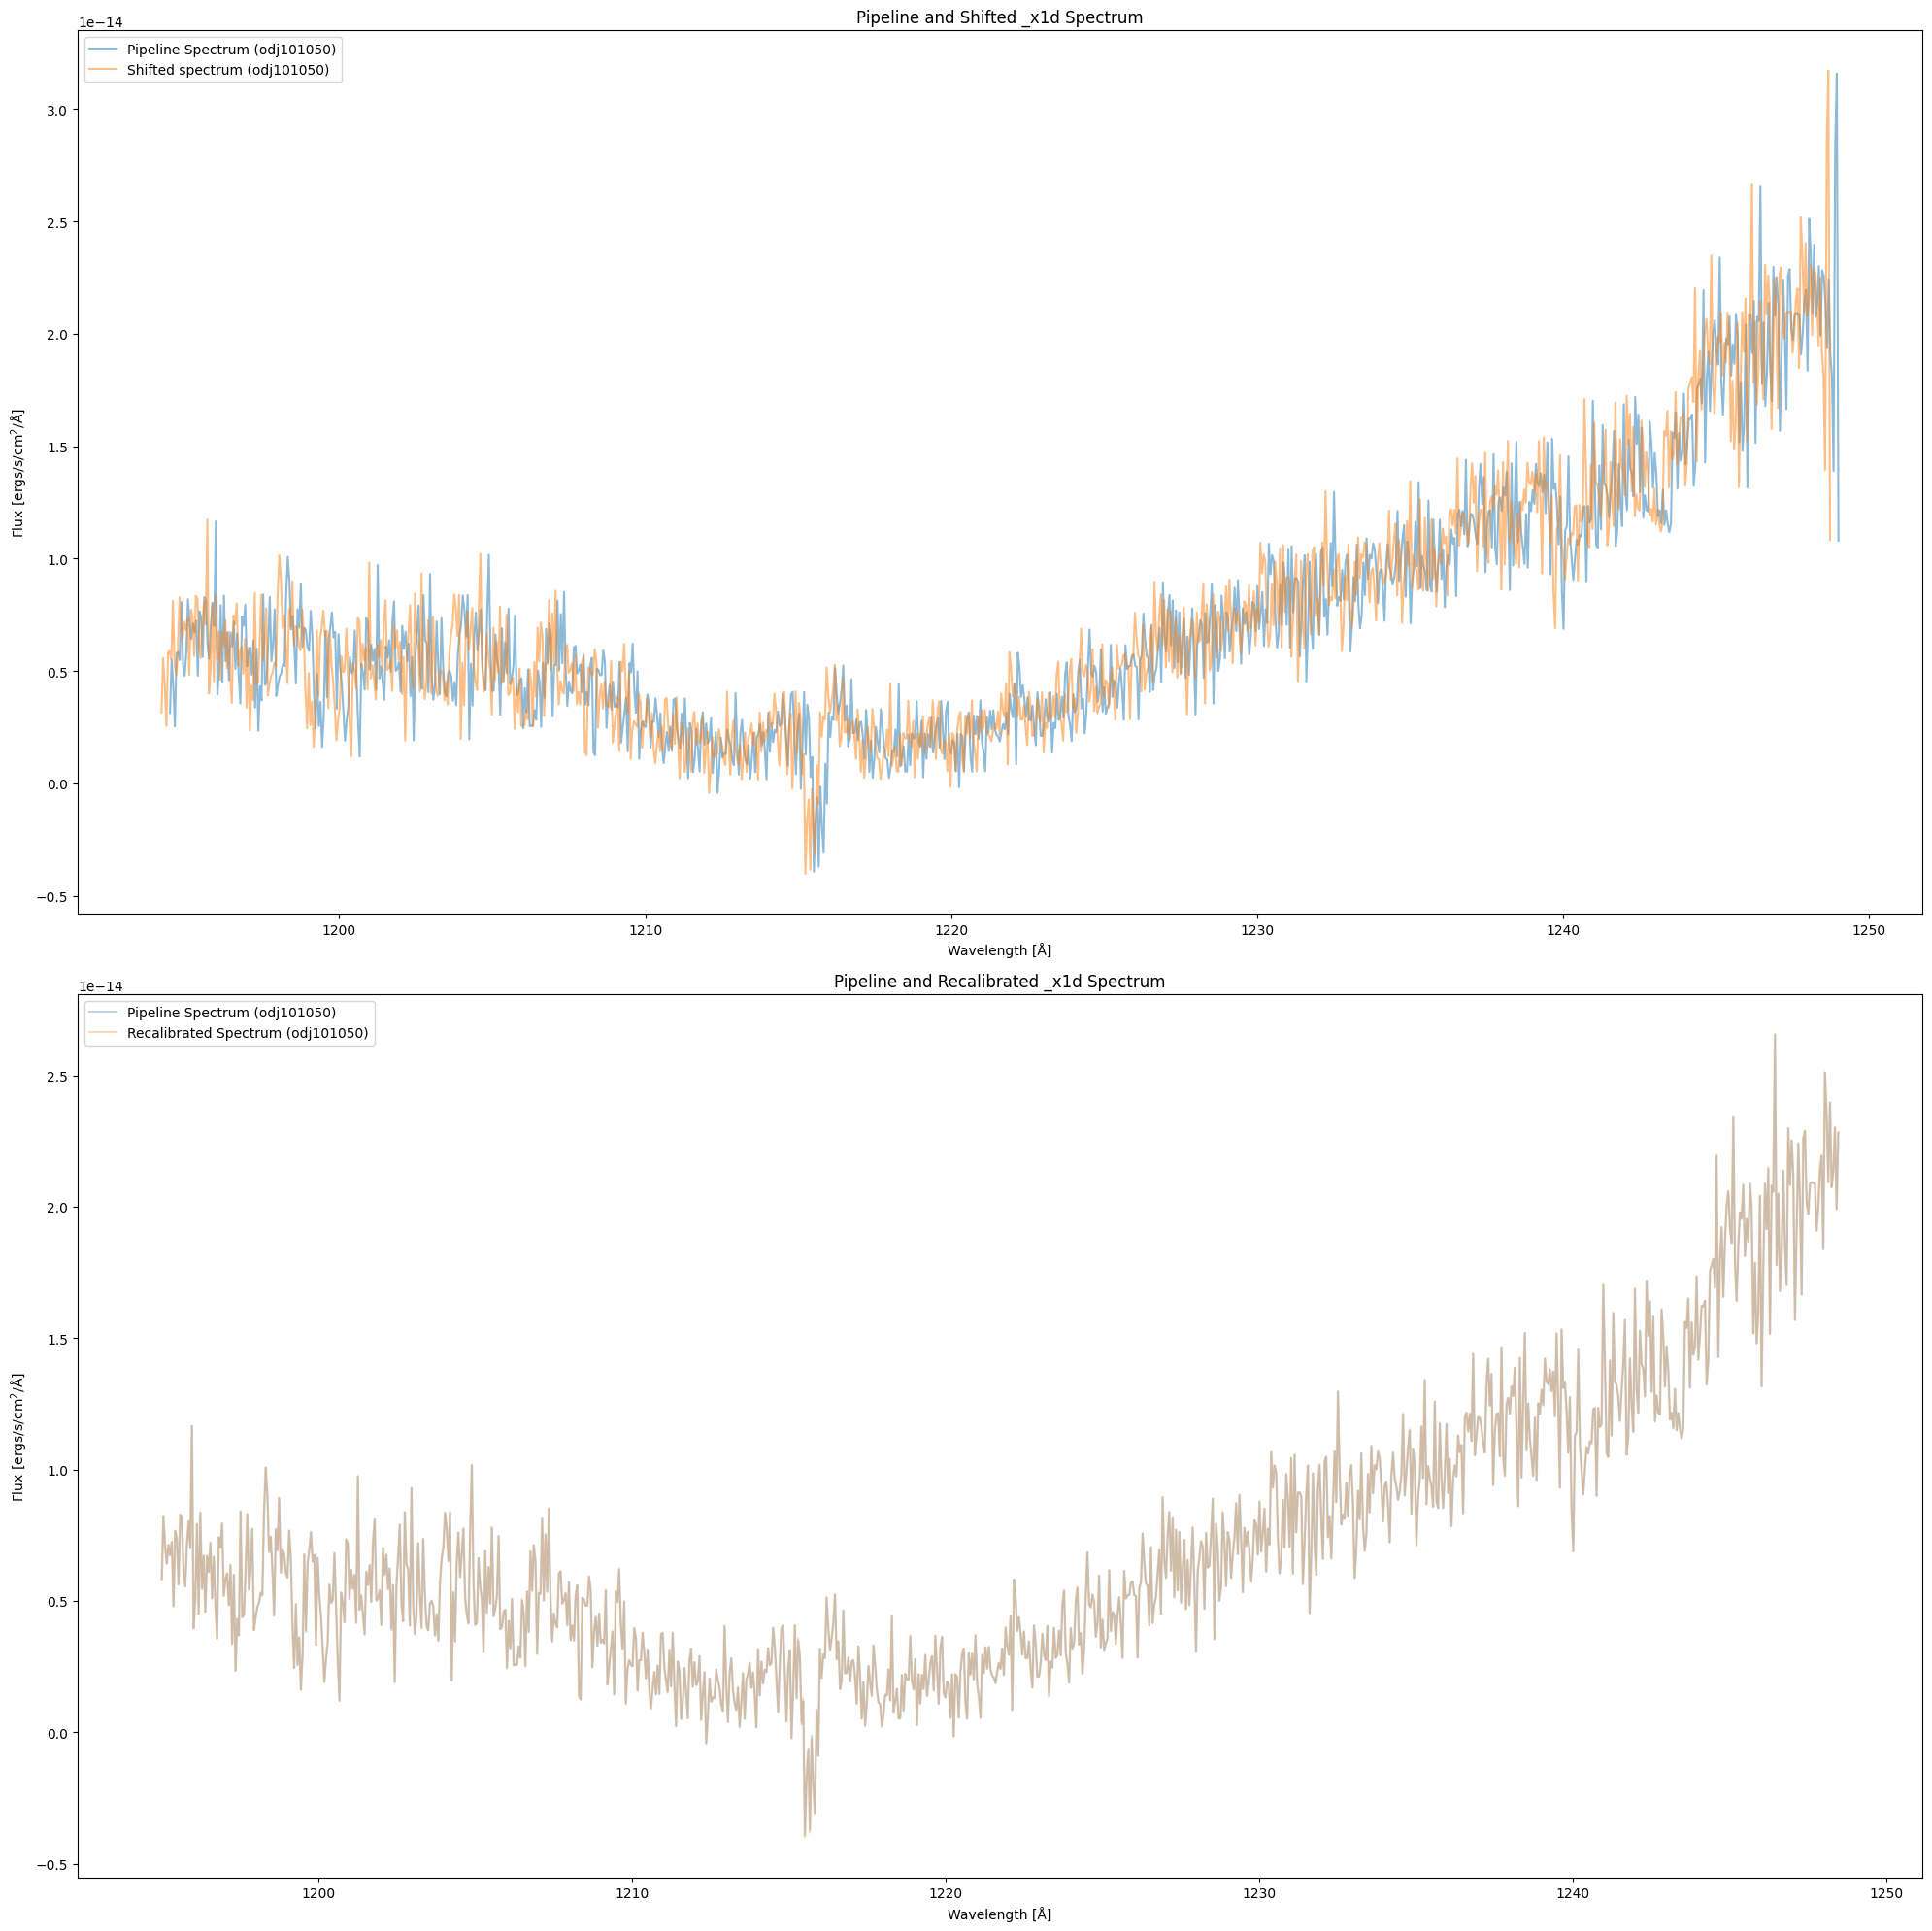

In [19]:
fig = plt.figure(figsize=(20, 20))
plt.subplot(2, 1, 1)
with fits.open(pip_x1d) as hdu1, fits.open(shifted_x1d) as hdu2:
    pip_wl = hdu1[1].data["WAVELENGTH"][0]
    pip_flux = hdu1[1].data["FLUX"][0]
    
    shifted_wl = hdu2[1].data["WAVELENGTH"][0]
    shifted_flux = hdu2[1].data["FLUX"][0]
    
plt.plot(pip_wl, pip_flux, label="Pipeline Spectrum ({})".format(target_id), alpha=0.5)
plt.plot(shifted_wl, shifted_flux, label="Shifted spectrum ({})".format(target_id), alpha=0.5)
plt.legend(loc="best")
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [ergs/s/cm$^2$/Å]")
plt.title("Pipeline and Shifted _x1d Spectrum")

plt.subplot(2, 1, 2)
with fits.open(pip_x1d) as hdu1, fits.open(recal_x1d) as hdu2:
    wl1 = hdu1[1].data["WAVELENGTH"][0][10:-10]
    wl2 = hdu2[1].data["WAVELENGTH"][0][10:-10]
    
    flux1 = hdu1[1].data["FLUX"][0][10:-10]
    flux2 = hdu2[1].data["FLUX"][0][10:-10]
plt.plot(wl1, flux1, label="Pipeline Spectrum ({})".format(target_id), alpha=0.3)
plt.plot(wl2, flux2, label="Recalibrated Spectrum ({})".format(target_id), alpha=0.3)
plt.legend(loc="best")
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux [ergs/s/cm$^2$/Å]")
plt.title("Pipeline and Recalibrated _x1d Spectrum")
plt.tight_layout()


---
## About this Notebook <a class="tocSkip">
**Author:** [Keyi Ding](kding@stsci.edu)

**Updated On:** 2023-04-14


> *This tutorial was generated to be in compliance with the [STScI style guides](https://github.com/spacetelescope/style-guides) and would like to cite the [Jupyter guide](https://github.com/spacetelescope/style-guides/blob/master/templates/example_notebook.ipynb) in particular.*
## Citations <a class="tocSkip">

If you use `astropy`, `matplotlib`, `astroquery`, or `numpy` for published research, please cite the
authors. Follow these links for more information about citations:

* [Citing `astropy`/`numpy`/`matplotlib`](https://www.scipy.org/citing.html)
* [Citing `astroquery`](https://astroquery.readthedocs.io/en/latest/)

---

[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 